In this first part, we install import all the packages used

In [1]:
#Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#Subpackages
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix



#ImportFunctions
from Functions import fetch_data
from Functions import moving_average
from Functions import rsi
from Functions import macd
from Functions import lagged_return
from Functions import bollinger_bands
from Functions import pe_ratio
from Functions import daily_returns



In [2]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
from keras.callbacks import EarlyStopping

# Evaluation and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

# Ensure that TensorFlow is using GPU (if available)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

# Check TensorFlow version for reference
print("TensorFlow Version:", tf.__version__)

No GPU found. Using CPU.
TensorFlow Version: 2.14.0


Next, we import some stock data

In [3]:
tickers = ['TSLA', 'AAPL', 'AMZN', 'GOOGL', 'AMD', 'GOOG', 'XOM', 'LLY', 'IBM', 'BAC', 'ADBE', 'HES', 'COST', 'ALGN', 'F', 'DIS', 'ANET', 'MO', 'AMT', 'HD', 'HON', 'ABBV', 'GE', 'ACN', 'ENPH', 'COP', 'AMAT', 'FDX', 'DHR', 'EW', 'GM', 'ABT', 'T', 'AMGN', 'ABNB', 'GS', 'HSY', 'ADP', 'ADI', 'DXCM', 'DG', 'AXP', 'EQIX', 'FI', 'GIS', 'AAL', 'CSX', 'FANG', 'DE', 'CVS', 'DLR', 'EMR', 'ADSK', 'GD', 'HAS', 'AZO', 'GILD', 'HUM', 'CCI', 'FCX', 'HCA', 'MMM', 'AON', 'HAL', 'ETN', 'BKR', 'APH', 'DAL', 'HLT', 'AMP', 'IDXX', 'CTRA', 'ALB', 'FTNT', 'EQT', 'ELV', 'EOG', 'DOW', 'ITW', 'D', 'AJG', 'EXC', 'EXPE', 'DUK', 'DLTR', 'FICO', 'DVN', 'GPN', 'EG', 'ETSY', 'AEP', 'DHI', 'HPQ', 'ADM', 'ALL', 'EBAY', 'AVB', 'EL', 'GEHC', 'IEX']
start_date = "2013-10-01"
end_date = "2023-10-01"

stock_data = fetch_data(tickers, start_date, end_date)

Now we calculate the technical indicators for each stock

In [4]:
# For each stock's data, compute the technical indicators and add them as new columns to the DataFrame

for ticker, data in stock_data.items():
    # Backup the 'Close' prices
    close_prices = data['Close'].copy()
    
    # 20-day Moving Average
    data['MA20'] = moving_average(data)
    
    # RSI
    data['RSI'] = rsi(data)
    
    # MACD
    data['MACD'], data['Signal_Line'] = macd(data)
    
    # 1, 2, and 3 Day Lagged Returns
    data['Lagged_Return_1'] = lagged_return(data, 1)
    data['Lagged_Return_2'] = lagged_return(data, 2)
    data['Lagged_Return_3'] = lagged_return(data, 3)
    
    # Bollinger Bands
    data['Upper_Bollinger'], data['Lower_Bollinger'] = bollinger_bands(data)
    
    # Restore 'Close' column
    data['Close'] = close_prices

    # Extract the 'Close' column
    close_prices = data['Close']
    
    # Calculate daily returns for all available days
    daily_returns = close_prices.pct_change().dropna()

    data['Daily_Returns'] = close_prices.pct_change().dropna()


    



Now that we have all the technical indicators for each stock we make a new dataframe that contains the data for all the stocks. We also do some data cleaning like removing the NANs. 

In [5]:
# Dictionary to store the split data for each stock
all_stock_data = {}

for ticker, data in stock_data.items():
    data_clean = data.dropna()  # drop rows with NaN values
    
    # Check if the cleaned data has a minimum number of rows
    if len(data_clean) < 10:
        print(f"Skipping {ticker} due to insufficient data.")
        continue

    # Features: using technical indicators and lagged returns
    X = data_clean[['RSI', 'MACD', 'Signal_Line', 'Lagged_Return_1', 'Lagged_Return_2', 'Lagged_Return_3', 'Upper_Bollinger', 'Lower_Bollinger']]

    # Target: Direction of the next day's return (1 for positive, 0 for negative or non-positive)
    y = (data_clean['Close'].pct_change().shift(-1) > 0).astype(int)

    # Splitting the data: 70% train, 15% validation, 15% test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)
    
    # Store the data splits in the dictionary
    all_stock_data[ticker] = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }

# Now, `all_stock_data` contains the data splits for all stocks.


We calculate the hold strategy for the backtest. We will use this later to compare the model to a simple go long strategy.

In [6]:
# Initialize the list to store results
stock_results_HOLD = []

# Keep track of the current index in all_X_test and all_y_test
current_idx = 0

# Loop through each ticker to extract predictions and actual returns
for ticker in all_stock_data:
    
    # Calculate the actual daily return for the stock
    # Access the 'Close' column directly from the original stock_data
    daily_returns = stock_data[ticker].loc[all_stock_data[ticker]['X_test'].index]['Close'].pct_change().shift(-1).dropna()
    
    # Append the results to the stock_results list
    stock_results_HOLD.append({
        'Ticker': ticker,
        'Actual Daily Returns': daily_returns.values
    })




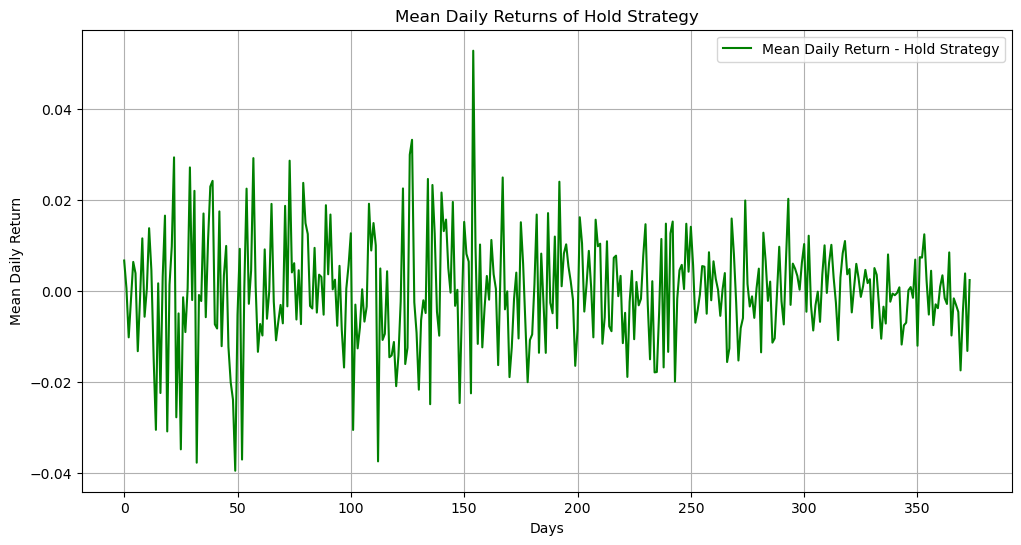

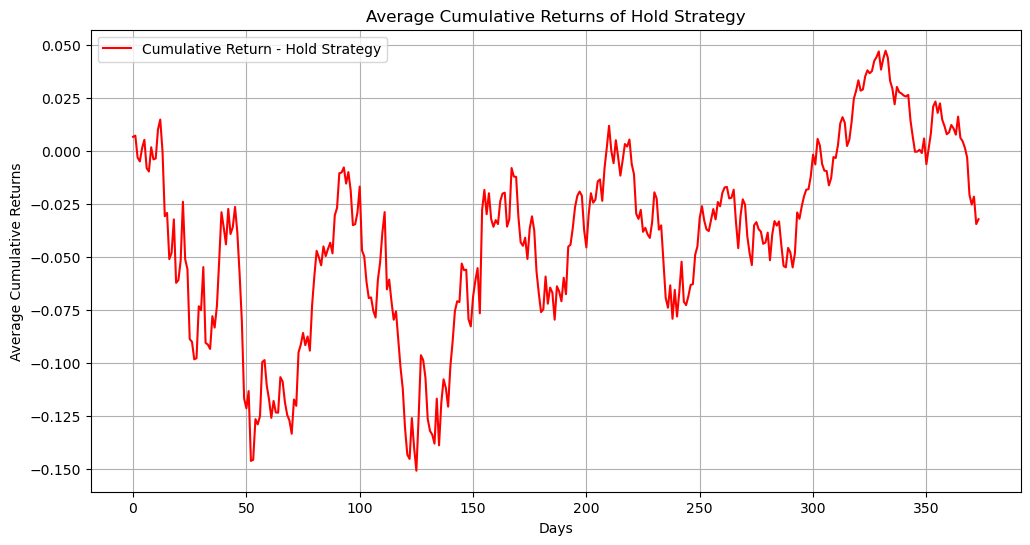

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize list to store daily returns for each stock
daily_returns_hold = []

for result in stock_results_HOLD:
    # Extract the actual daily returns
    actual_daily_returns = result['Actual Daily Returns']
    daily_returns_hold.append(actual_daily_returns)

# Pad daily returns to make them all the same length
max_length = max(map(len, daily_returns_hold))
padded_daily_returns = np.array([np.pad(returns, (0, max_length - len(returns)), 'constant', constant_values=np.nan) for returns in daily_returns_hold])

# Calculate the mean daily return across all stocks for each day
mean_daily_returns_hold = np.nanmean(padded_daily_returns, axis=0)

# Calculate the cumulative product of (1 + mean daily returns) - 1 for cumulative return
mean_cumulative_returns_hold = (1 + mean_daily_returns_hold).cumprod() - 1

# Plot the mean daily returns
plt.figure(figsize=(12, 6))
plt.plot(mean_daily_returns_hold, label="Mean Daily Return - Hold Strategy", color='green')
plt.title("Mean Daily Returns of Hold Strategy")
plt.xlabel("Days")
plt.ylabel("Mean Daily Return")
plt.legend()
plt.grid(True)
plt.show()

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(mean_cumulative_returns_hold, label="Cumulative Return - Hold Strategy", color='red')
plt.title("Average Cumulative Returns of Hold Strategy")
plt.xlabel("Days")
plt.ylabel("Average Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()


Now, we normalize the data to pe ready for Neural network

In [8]:
from sklearn.preprocessing import StandardScaler

# Iterate over each stock's data
for ticker, data_splits in all_stock_data.items():
    scaler = StandardScaler()

    # Scale the training data and convert it back to DataFrame to keep the index
    X_train_scaled = scaler.fit_transform(data_splits['X_train'])
    data_splits['X_train'] = pd.DataFrame(X_train_scaled, index=data_splits['X_train'].index, columns=data_splits['X_train'].columns)

    # Do the same for the validation and test data
    X_val_scaled = scaler.transform(data_splits['X_val'])
    data_splits['X_val'] = pd.DataFrame(X_val_scaled, index=data_splits['X_val'].index, columns=data_splits['X_val'].columns)

    X_test_scaled = scaler.transform(data_splits['X_test'])
    data_splits['X_test'] = pd.DataFrame(X_test_scaled, index=data_splits['X_test'].index, columns=data_splits['X_test'].columns)

    # Update the dictionary with scaled data
    all_stock_data[ticker] = data_splits


In [9]:
print(X_test)

                  RSI      MACD  Signal_Line  Lagged_Return_1  \
Date                                                            
2022-03-31  53.637305 -0.386446    -0.819105        -0.015520   
2022-04-01  55.365267 -0.556917    -0.766667        -0.018631   
2022-04-04  51.518608 -0.578833    -0.729100         0.002243   
2022-04-05  41.749172 -0.697098    -0.722700         0.006869   
2022-04-06  43.201917 -0.585574    -0.695275        -0.006977   
...               ...       ...          ...              ...   
2023-09-21  15.341138 -2.978682    -1.445437        -0.004599   
2023-09-22  10.467346 -3.308467    -1.818043        -0.015004   
2023-09-25  15.599332 -3.480481    -2.150531         0.001644   
2023-09-26  13.019883 -3.889091    -2.498243         0.002945   
2023-09-27  27.897731 -3.875334    -2.773661        -0.018918   

            Lagged_Return_2  Lagged_Return_3  Upper_Bollinger  Lower_Bollinger  
Date                                                                     

Now we actually make the classifier to predict the stock direction. We use a random forest model to determine this.

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# Import necessary libraries from Keras Tuner
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import classification_report

# Define the model with hyperparameters
# Define the model with hyperparameters, now including the number of layers
def build_model(hp):
    model = Sequential()

    # we choose a number of dense layers between 2 and 5
    for i in range(hp.Int('num_layers', 2, 5)):
        # Add dense layers with a number of units and a dropout layer following each
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                        activation='relu', input_shape=(combined_X_train.shape[1],) if i==0 else []))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer with a single unit for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with a choice of learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Combine all the training and validation data
combined_X_train = np.vstack([all_stock_data[ticker]['X_train'] for ticker in all_stock_data])
combined_y_train = np.hstack([all_stock_data[ticker]['y_train'] for ticker in all_stock_data])
combined_X_val = np.vstack([all_stock_data[ticker]['X_val'] for ticker in all_stock_data])
combined_y_val = np.hstack([all_stock_data[ticker]['y_val'] for ticker in all_stock_data])

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10, 
    executions_per_trial=4,
    directory='tuning_dir',
    project_name='combined_stock_data'
)

# Search for the best hyperparameters
tuner.search(combined_X_train, combined_y_train, epochs=100, validation_data=(combined_X_val, combined_y_val))  

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=10)[0]

# Build the best model
model = tuner.hypermodel.build(best_hps)
model.fit(combined_X_train, combined_y_train, epochs=100, batch_size=32, verbose=1, validation_data=(combined_X_val, combined_y_val))

# Validate the model
_, accuracy = model.evaluate(combined_X_val, combined_y_val, verbose=0)

# Predict the validation data
y_val_pred = (model.predict(combined_X_val) > 0.5).astype(int).flatten()

# Performance report
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(combined_y_val, y_val_pred))

# Save the model if needed
model.save('ModelSaved')


Using TensorFlow backend
Reloading Tuner from tuning_dir\combined_stock_data\tuner0.json
Epoch 1/100
5326/5326 [==============================] - 15s 3ms/step - loss: 0.6913 - accuracy: 0.5257 - val_loss: 0.6948 - val_accuracy: 0.5198
Epoch 2/100
5326/5326 [==============================] - 16s 3ms/step - loss: 0.6871 - accuracy: 0.5411 - val_loss: 0.6943 - val_accuracy: 0.5355
Epoch 3/100
5326/5326 [==============================] - 15s 3ms/step - loss: 0.6843 - accuracy: 0.5499 - val_loss: 0.7221 - val_accuracy: 0.5237
Epoch 4/100
5326/5326 [==============================] - 15s 3ms/step - loss: 0.6830 - accuracy: 0.5531 - val_loss: 0.7112 - val_accuracy: 0.5283
Epoch 5/100
5326/5326 [==============================] - 16s 3ms/step - loss: 0.6821 - accuracy: 0.5549 - val_loss: 0.7034 - val_accuracy: 0.5395
Epoch 6/100
5326/5326 [==============================] - 17s 3ms/step - loss: 0.6815 - accuracy: 0.5544 - val_loss: 0.7058 - val_accuracy: 0.5344
Epoch 7/100
5326/5326 [============

INFO:tensorflow:Assets written to: ModelSaved\assets


After we have trained the model on the validation set, we will now test on an out of sample test. In other words, we test on new data.

In [11]:
from sklearn.metrics import accuracy_score, classification_report

# Dictionary to store test set performances
test_performances = {}

# List to store all accuracy scores
all_accuracies = []

# Use the single trained model for predictions on each stock's test data
for ticker in all_stock_data:
    # Get the test data for the current stock
    X_test = all_stock_data[ticker]['X_test']
    y_test = all_stock_data[ticker]['y_test']

    # Predict using the single trained model
    y_test_pred_probs = model.predict(X_test)
    y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to class labels
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Store the performance on the test set
    test_performances[ticker] = {
        'Test Accuracy': test_accuracy,
        'Test Classification Report': classification_report(y_test, y_test_pred, output_dict=True)
    }

    # Add the accuracy to the list
    all_accuracies.append(test_accuracy)

    # Print out the test performance for the current stock
    print(f"Test Performance for {ticker}:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, y_test_pred))
    print("-------------------------------------------------")

# Calculate and print the average accuracy
average_accuracy = sum(all_accuracies) / len(all_accuracies)
print(f"Average Test Accuracy across all stocks: {average_accuracy:.4f}")


12/12 [==============================] - 0s 3ms/step
Test Performance for TSLA:
Test Accuracy: 0.5067
              precision    recall  f1-score   support

           0       0.50      0.84      0.63       184
           1       0.55      0.18      0.27       191

    accuracy                           0.51       375
   macro avg       0.52      0.51      0.45       375
weighted avg       0.52      0.51      0.45       375

-------------------------------------------------
12/12 [==============================] - 0s 2ms/step
Test Performance for AAPL:
Test Accuracy: 0.4800
              precision    recall  f1-score   support

           0       0.48      0.59      0.53       184
           1       0.49      0.38      0.42       191

    accuracy                           0.48       375
   macro avg       0.48      0.48      0.48       375
weighted avg       0.48      0.48      0.47       375

-------------------------------------------------
12/12 [==============================] - 0

c:\Anaconda\envs\corporate_finance\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\envs\corporate_finance\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\envs\corporate_finance\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\envs\corporat

12/12 [==============================] - 0s 3ms/step
Test Performance for EBAY:
Test Accuracy: 0.5467
              precision    recall  f1-score   support

           0       0.57      0.43      0.49       191
           1       0.53      0.67      0.59       184

    accuracy                           0.55       375
   macro avg       0.55      0.55      0.54       375
weighted avg       0.55      0.55      0.54       375

-------------------------------------------------
12/12 [==============================] - 0s 2ms/step
Test Performance for AVB:
Test Accuracy: 0.5467
              precision    recall  f1-score   support

           0       0.58      0.50      0.54       196
           1       0.52      0.60      0.56       179

    accuracy                           0.55       375
   macro avg       0.55      0.55      0.55       375
weighted avg       0.55      0.55      0.55       375

-------------------------------------------------
12/12 [==============================] - 0s

Now we start backtesting the models. We make a list that includes the predicted return and the actual return.

In [12]:
for ticker, stock_data in all_stock_data.items():
    
    # Create an empty DataFrame for each stock
    df = pd.DataFrame(columns=['Date', 'daily return', 'Neural Network'])

    # Get the test data for the current stock
    X_test = stock_data['X_test']
    y_test = stock_data['y_test']

    # Assuming test_dates are the dates aligned with X_test
    test_dates = data.index[-len(X_test):]

    # Retrieve the 'Close' prices for the test dates
    Returndata = data.loc[test_dates, 'Close']

    # Calculate the daily returns for the 'Close' prices
    daily_returns = Returndata.pct_change()

    # Predict using the single trained neural network model
    y_test_pred_nn = (model.predict(X_test) > 0.5).astype(int).flatten()

    # Create a DataFrame for the current stock
    ResultsReturnAndPrediction = pd.DataFrame({
        'Date': test_dates,
        'daily return': daily_returns.tolist(),
        'Neural Network': y_test_pred_nn.tolist()
    })

    # Append the stock DataFrame to the main DataFrame
    df = pd.concat([df, ResultsReturnAndPrediction], ignore_index=True)

    # Drop rows with NaN values in any column
    df = df.dropna()

    # Print the resulting DataFrame for each stock
    print(f"Data for {ticker}:")
    print(df)


12/12 [==============================] - 0s 3ms/step
Data for TSLA:
          Date  daily return Neural Network
1   2022-04-05     -0.006977              0
2   2022-04-06      0.012804              0
3   2022-04-07      0.021224              0
4   2022-04-08     -0.009461              0
5   2022-04-11     -0.008687              0
..         ...           ...            ...
370 2023-09-25      0.002945              0
371 2023-09-26     -0.018918              0
372 2023-09-27      0.017811              0
373 2023-09-28      0.007809              0
374 2023-09-29     -0.004975              0

[374 rows x 3 columns]
12/12 [==============================] - 0s 3ms/step
Data for AAPL:
          Date  daily return Neural Network
1   2022-04-05     -0.006977              0
2   2022-04-06      0.012804              0
3   2022-04-07      0.021224              0
4   2022-04-08     -0.009461              0
5   2022-04-11     -0.008687              0
..         ...           ...            ...
370 

We perform the backtest and plot the results

12/12 [==============================] - 0s 1ms/step
All predictions for ADM are the same.
12/12 [==============================] - 0s 1ms/step


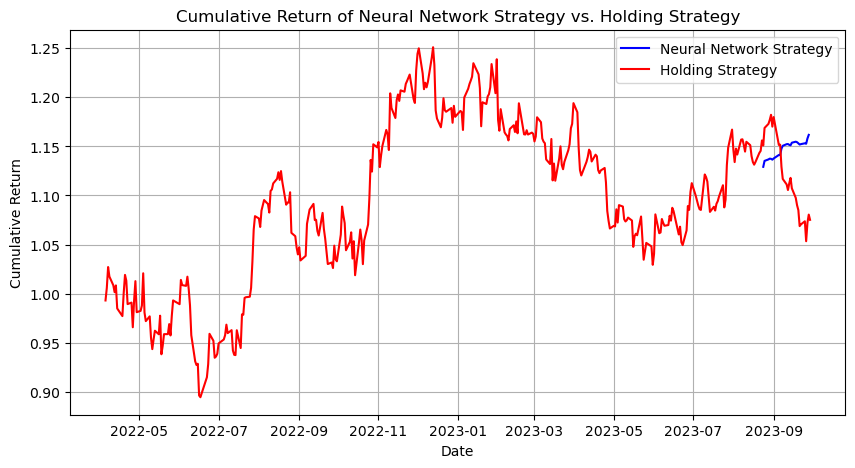

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Data structures to store daily and strategy returns for all stocks before creating DataFrame
all_daily_returns = {}
all_strategy_returns = {}

for ticker, stock_data in all_stock_data.items():
    
    # Extract the test data and the returns data
    X_test = stock_data['X_test']
    y_test = stock_data['y_test']

    # Assuming test_dates are the dates aligned with X_test
    test_dates = data.index[-len(X_test):]

    # Retrieve the 'Close' prices for the test dates
    Returndata = data.loc[test_dates, 'Close']

    # Calculate the daily returns for the 'Close' prices
    daily_returns = Returndata.pct_change()
    all_daily_returns[ticker] = daily_returns  # Collect daily returns for each stock

    # Predict using the single trained neural network model
    y_test_pred_nn = (model.predict(X_test) > 0.5).astype(int).flatten()
    
    # Check if all predictions are the same
    if len(set(y_test_pred_nn)) == 1:
        print(f"All predictions for {ticker} are the same.")
        continue

    # Convert predictions to a Series with the test dates as its index
    y_test_pred_nn_series = pd.Series(y_test_pred_nn, index=test_dates)

    # Shift the predictions by one day forward
    y_test_pred_nn_series_shifted = y_test_pred_nn_series.shift(-1)

    # Calculate strategy daily returns based on the shifted predictions
    strategy_returns_nn = daily_returns * (2 * y_test_pred_nn_series_shifted - 1)

    # Collect strategy daily returns for each stock
    all_strategy_returns[ticker] = strategy_returns_nn
    all_strategy_returns[f"{ticker}_NN_Strategy"] = (1 + strategy_returns_nn).cumprod()

# Create DataFrames from the collected data
df_daily_returns_all_stocks = pd.DataFrame(all_daily_returns)
df_strategy_returns_all_stocks = pd.DataFrame(all_strategy_returns)

# Remove NaN values that are a result of the shift in predictions
df_strategy_returns_all_stocks = df_strategy_returns_all_stocks.dropna()

# Calculate cumulative returns for holding strategy
cumulative_returns_holding = (1 + df_daily_returns_all_stocks.mean(axis=1)).cumprod()

# Calculate cumulative returns for the neural network strategy
cumulative_returns_nn_strategy = df_strategy_returns_all_stocks.filter(like="_NN_Strategy").mean(axis=1)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns_nn_strategy.index, cumulative_returns_nn_strategy.values, label='Neural Network Strategy', color='blue')
plt.plot(cumulative_returns_holding.index, cumulative_returns_holding.values, label='Holding Strategy', color='red')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return of Neural Network Strategy vs. Holding Strategy')
plt.legend()
plt.grid(True)
plt.show()


Nu tester vi lige på en af aktierne og ser om den faktisk også bruger predictions på de rigtige dage. OVENSTÅENDE PLOT BRUGER IKKE PREDICTIONS RIGTIGT... Vi analyserer ikke på den. HOLDING STRATEGY ER OGSÅ FORKERT...

In [14]:
# Select a ticker to display the table for
selected_ticker = 'AAPL'  # Replace with your ticker

# Assuming df_strategy_returns_all_stocks contains the daily strategy returns for all stocks
# and df_daily_returns_all_stocks contains the daily raw returns for all stocks
# Retrieve the relevant data for the selected ticker
strategy_daily_returns = df_strategy_returns_all_stocks[selected_ticker].dropna()
raw_daily_returns = df_daily_returns_all_stocks[selected_ticker].loc[strategy_daily_returns.index]

# Calculate cumulative strategy returns
cumulative_strategy_returns = (1 + strategy_daily_returns).cumprod()

# Retrieve the predictions and ensure they align with the strategy_daily_returns index
predictions = (model.predict(all_stock_data[selected_ticker]['X_test'][-len(strategy_daily_returns):]) > 0.5).astype(int).flatten()

# Create a DataFrame with the required information
df_summary = pd.DataFrame({
    'Date': strategy_daily_returns.index,
    'Daily Return': raw_daily_returns.values,
    'Cumulative Strategy Return': cumulative_strategy_returns.values,
    'Prediction': predictions
})

# Display the first 15 days
df_summary_head = df_summary.head(15)

print(df_summary_head)


1/1 [==============================] - 0s 31ms/step
         Date  Daily Return  Cumulative Strategy Return  Prediction
0  2023-08-24     -0.004426                    0.995574           1
1  2023-08-25      0.015492                    1.010998           1
2  2023-08-28      0.003538                    1.007421           0
3  2023-08-29      0.003481                    1.003914           0
4  2023-08-30      0.004391                    0.999506           0
5  2023-08-31     -0.010187                    1.009688           0
6  2023-09-01      0.008304                    1.018072           1
7  2023-09-05     -0.024093                    1.042601           0
8  2023-09-06      0.000269                    1.042320           0
9  2023-09-07     -0.019476                    1.062620           0
10 2023-09-08     -0.011030                    1.074340           0
11 2023-09-11     -0.005044                    1.079760           0
12 2023-09-12     -0.005116                    1.085284         

Nu tester beregner vi det gennemsnitlige afkast for de to strategier fordelt over alle aktierne. 

In [15]:
# Create a DataFrame to store the strategy's daily returns for each stock
df_strategy_daily_returns = pd.DataFrame(index=df_daily_returns_all_stocks.index)

for ticker in all_stock_data:
    # Get the actual daily returns for the stock
    actual_daily_returns = df_daily_returns_all_stocks[ticker]
    
    # Get the predictions for the stock
    predictions = (model.predict(all_stock_data[ticker]['X_test']) > 0.5).astype(int).flatten()
    
    # Align the predictions with the actual daily returns
    aligned_predictions = pd.Series(predictions, index=all_stock_data[ticker]['X_test'].index).reindex(actual_daily_returns.index, fill_value=np.nan)
    
    # Calculate the strategy's daily returns for this stock
    strategy_daily_returns = actual_daily_returns.shift(-1) * (2 * aligned_predictions - 1) #correct here for shift
    
    # Store the strategy's daily returns
    df_strategy_daily_returns[ticker] = strategy_daily_returns

# Calculate cumulative returns for each stock's strategy
df_cumulative_strategy_returns = (1 + df_strategy_daily_returns).cumprod()

# Calculate the average cumulative returns for the strategy across all stocks
# Use `skipna=True` to only average over available data
average_cumulative_strategy_returns = df_cumulative_strategy_returns.mean(axis=1, skipna=True)

# The average daily returns are the same as before
# Use `mean` with `skipna=True` to only average over available data
average_daily_returns = df_daily_returns_all_stocks.mean(axis=1, skipna=True)

# calculation for the holding strategy's cumulative returns
average_cumulative_returns_holding = (1 + average_daily_returns).cumprod()

# Create a DataFrame with the required information
df_average_summary = pd.DataFrame({
    'Date': df_strategy_daily_returns.index,
    'Average Daily Return': average_daily_returns,
    'Average Cumulative Holding Return': average_cumulative_returns_holding,
    'Average Cumulative Strategy Return': average_cumulative_strategy_returns
})

# Display the first 15 days of the average summary
df_average_summary_head = df_average_summary.tail(15)
print(df_average_summary_head)


12/12 [==============================] - 0s 2ms/step
                 Date  Average Daily Return  \
Date                                          
2023-09-11 2023-09-11             -0.005044   
2023-09-12 2023-09-12             -0.005116   
2023-09-13 2023-09-13              0.006171   
2023-09-14 2023-09-14              0.005018   
2023-09-15 2023-09-15             -0.009524   
2023-09-18 2023-09-18             -0.008775   
2023-09-19 2023-09-19             -0.006828   
2023-09-20 2023-09-20             -0.004599   
2023-09-21 2023-09-21             -0.015004   
2023-09-22 2023-09-22              0.001644   
2023-09-25 2023-09-25              0.002945   
2023-09-26 2023-09-26             -0.018918   
2023-09-27 2023-09-27              0.017811   
2023-09-28 2023-09-28              0.007809   
2023-09-29 2023-09-29             -0.004975   

            Average Cumulative Holding Return  \
Date                                            
2023-09-11                           1.111226   


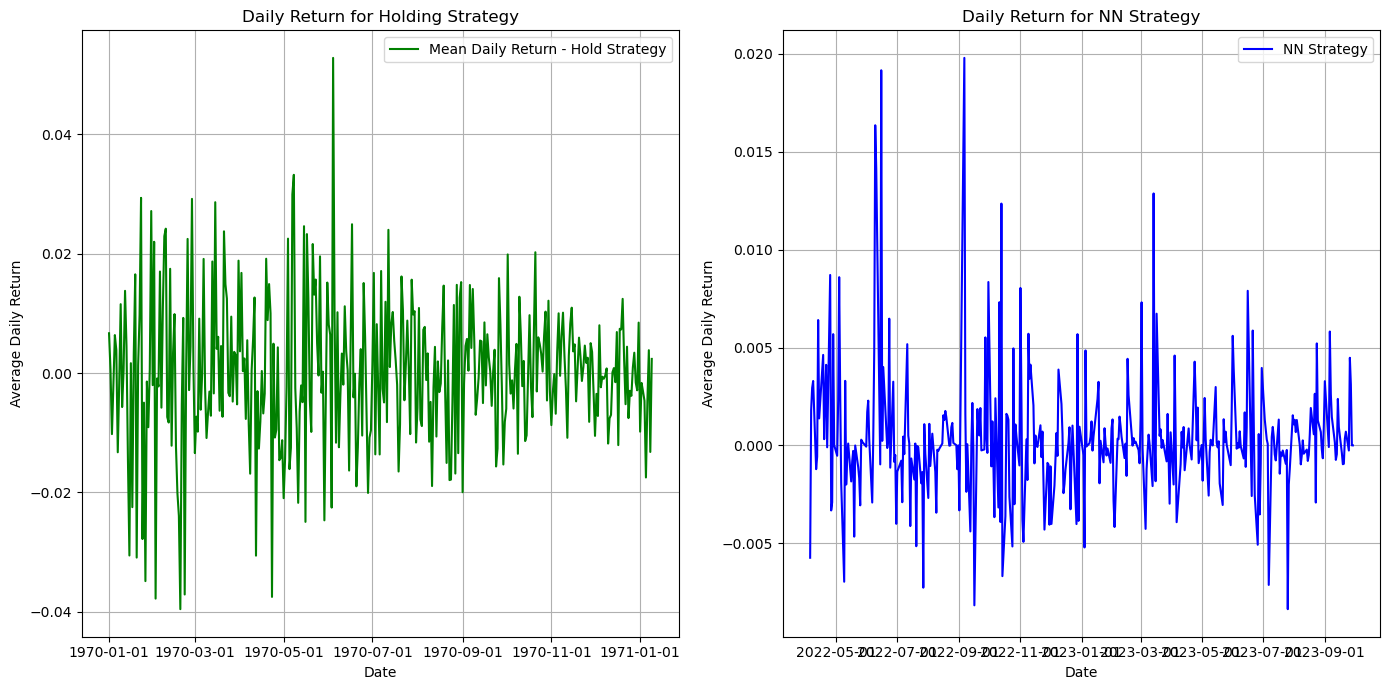

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure 'Date' is in datetime format
df_average_summary['Date'] = pd.to_datetime(df_average_summary['Date'])

# Calculate daily returns for the neural network strategy
df_average_summary['Daily Return NN Strategy'] = df_average_summary['Average Cumulative Strategy Return'].pct_change().fillna(0)

# Convert mean_cumulative_returns_hold to a pandas Series
# Make sure to align the dates properly if they are not already aligned
if len(mean_cumulative_returns_hold) != len(df_average_summary['Date']):
    # If mean_cumulative_returns_hold is shorter, align it with the end of df_average_summary['Date']
    aligned_dates = df_average_summary['Date'][-len(mean_cumulative_returns_hold):]
else:
    aligned_dates = df_average_summary['Date']

mean_cumulative_returns_hold_series = pd.Series(mean_cumulative_returns_hold, index=aligned_dates)

# Calculate the percent change for the holding strategy
df_average_summary['Daily Return Hold Strategy'] = mean_cumulative_returns_hold_series.pct_change().fillna(0)

# Now, plot the data
plt.figure(figsize=(14, 7))

# Plot daily returns for the holding strategy
plt.subplot(1, 2, 1)
plt.plot(mean_daily_returns_hold, label="Mean Daily Return - Hold Strategy", color='green')
plt.xlabel('Date')
plt.ylabel('Average Daily Return')
plt.title('Daily Return for Holding Strategy')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the dates on x-axis
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Set locator

# Plot daily returns for the neural network strategy
plt.subplot(1, 2, 2)
plt.plot(aligned_dates, df_average_summary.loc[aligned_dates, 'Daily Return NN Strategy'], label='NN Strategy', color='blue')
plt.xlabel('Date')
plt.ylabel('Average Daily Return')
plt.title('Daily Return for NN Strategy')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the dates on x-axis
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Set locator

plt.tight_layout()
plt.show()


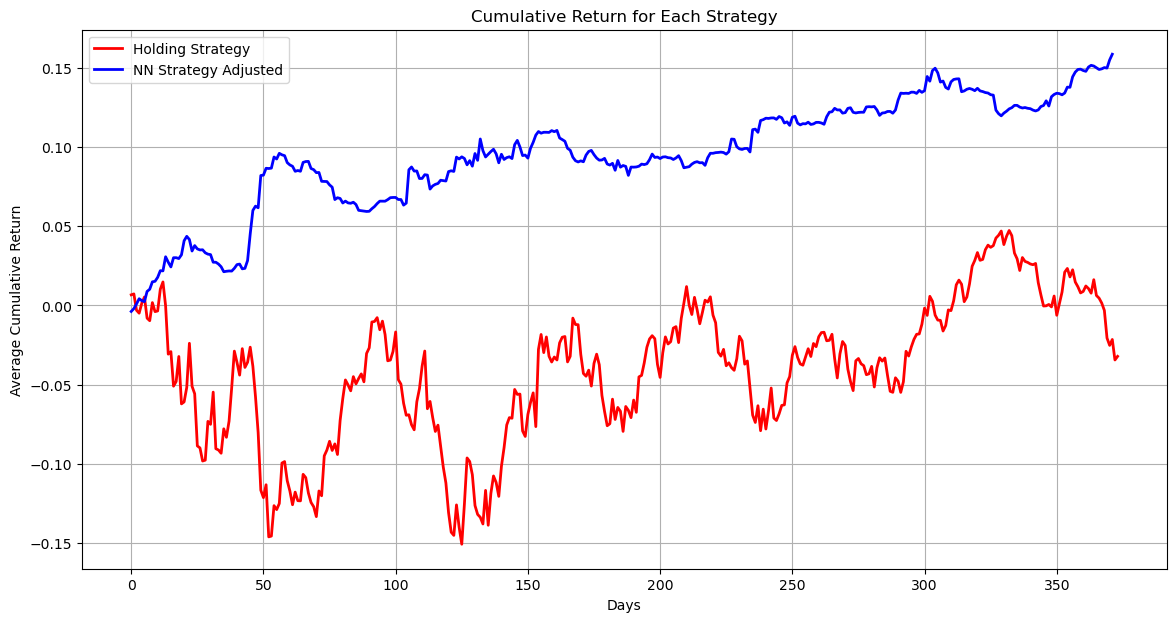

In [17]:
import matplotlib.dates as mdates

# Plot cumulative returns for each strategy
plt.figure(figsize=(14, 7))

# Create a range of days for the x-axis
days_range = range(len(mean_cumulative_returns_hold))

# Subtract 1 from the NN strategy returns to align it with the holding strategy at the start
adjusted_nn_returns = df_average_summary['Average Cumulative Strategy Return'][1:] - 1

# Plot cumulative returns for the holding strategy
plt.plot(days_range, mean_cumulative_returns_hold, label='Holding Strategy', color='red', linewidth=2)

# Plot cumulative returns for the neural network strategy, adjusted to start at 0
plt.plot(days_range, adjusted_nn_returns, label='NN Strategy Adjusted', color='blue', linewidth=2)

plt.xlabel('Days')
plt.ylabel('Average Cumulative Return')
plt.title('Cumulative Return for Each Strategy')
plt.legend()
plt.grid(True)

plt.show()


Now we calculate the sharpe ratios from the strategies

In [18]:
import numpy as np

# Assume the risk-free rate is 0 for simplicity
risk_free_rate = 0.0

# Calculate excess return from the neural network strategy
excess_daily_returns_nn_strategy = df_average_summary['Average Cumulative Strategy Return'].pct_change().fillna(0) - risk_free_rate

# Calculate the standard deviation of the excess daily returns 
std_dev_nn_strategy = excess_daily_returns_nn_strategy.std()

# Calculate the mean of excess daily returns for the NN strategy
mean_excess_daily_return_nn_strategy = excess_daily_returns_nn_strategy.mean()

# Calculate the Sharpe ratio without annualizing
sharpe_ratio_nn_strategy = mean_excess_daily_return_nn_strategy / std_dev_nn_strategy

# Print the Sharpe ratios
print(f"Neural Network Strategy Sharpe Ratio: {sharpe_ratio_nn_strategy:.4f}")


Neural Network Strategy Sharpe Ratio: 0.1204


In [ ]:
from scipy.stats import ttest_ind

# Calculate the daily returns for the hold strategy
daily_returns_hold = np.diff(np.array(mean_cumulative_returns_hold) + 1)

# Clean the data to ensure there are no NaN values
daily_returns_holding_clean = daily_returns_hold[~np.isnan(daily_returns_hold)]
daily_returns_nn_strategy_clean = df_average_summary['Average Cumulative Strategy Return'].pct_change().fillna(0).dropna().values

# Ensure both arrays have the same length for the t-test
min_length = min(len(daily_returns_holding_clean), len(daily_returns_nn_strategy_clean))
daily_returns_holding_clean = daily_returns_holding_clean[:min_length]
daily_returns_nn_strategy_clean = daily_returns_nn_strategy_clean[:min_length]

# Check if there's enough variation in the data
if daily_returns_holding_clean.std() == 0 or daily_returns_nn_strategy_clean.std() == 0:
    print("One of the series has no variation.")
else:
    # Perform the t-test
    t_stat, p_value = ttest_ind(daily_returns_nn_strategy_clean, daily_returns_holding_clean, equal_var=False)

    # Print the t-statistic and the p-value
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4g}")  # using 4 significant figures for the p-value

    # Interpret the p-value
    alpha = 0.45  # significance level
    if p_value < alpha:
        print("We reject the null hypothesis (There is a significant difference between the strategies)")
    else:
        print("We do not reject the null hypothesis (There is no significant difference between the strategies)")


T-statistic: 0.8091
P-value: 0.4189
We do not reject the null hypothesis (There is no significant difference between the strategies)


Ovenstående viser et t test på de gennemsnitlige værdier. Vi laver en ny test senere der viser for hvert enkelt aktie. Det er bedre fordi vi får mere data ud af det... Vi finder faktisk også at det ændrer resultatet helt. 

12/12 [==============================] - 0s 1ms/step


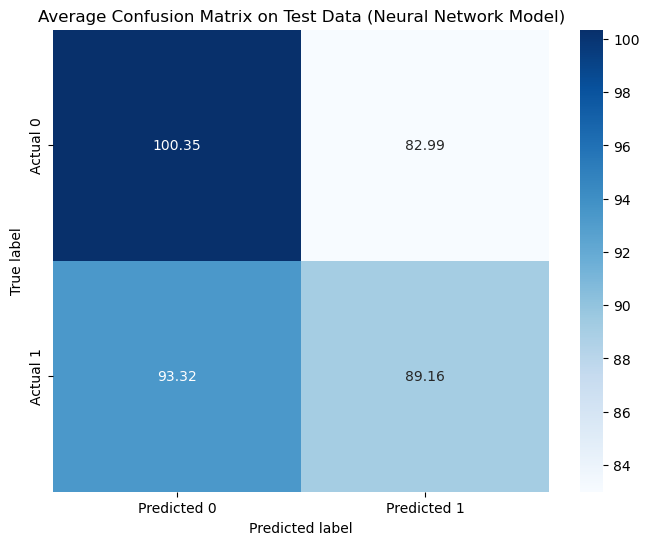

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Initialize a cumulative confusion matrix with zeros
cumulative_cm = np.zeros((2, 2))

# Loop through each ticker and its corresponding data in all_stock_data
for ticker, stock_data in all_stock_data.items():
    X_test = stock_data['X_test']
    y_test = stock_data['y_test']
    
    # Get predictions on the test set
    y_test_pred = (model.predict(X_test) > 0.5).astype(int).flatten()  # Threshold the predictions to get class labels
    
    # Add the confusion matrix for the current stock to the cumulative matrix
    cumulative_cm += confusion_matrix(y_test, y_test_pred)

# Calculate the average confusion matrix
average_cm = cumulative_cm / len(all_stock_data)

# Plot the average confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Average Confusion Matrix on Test Data (Neural Network Model)")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


12/12 [==============================] - 0s 2ms/step


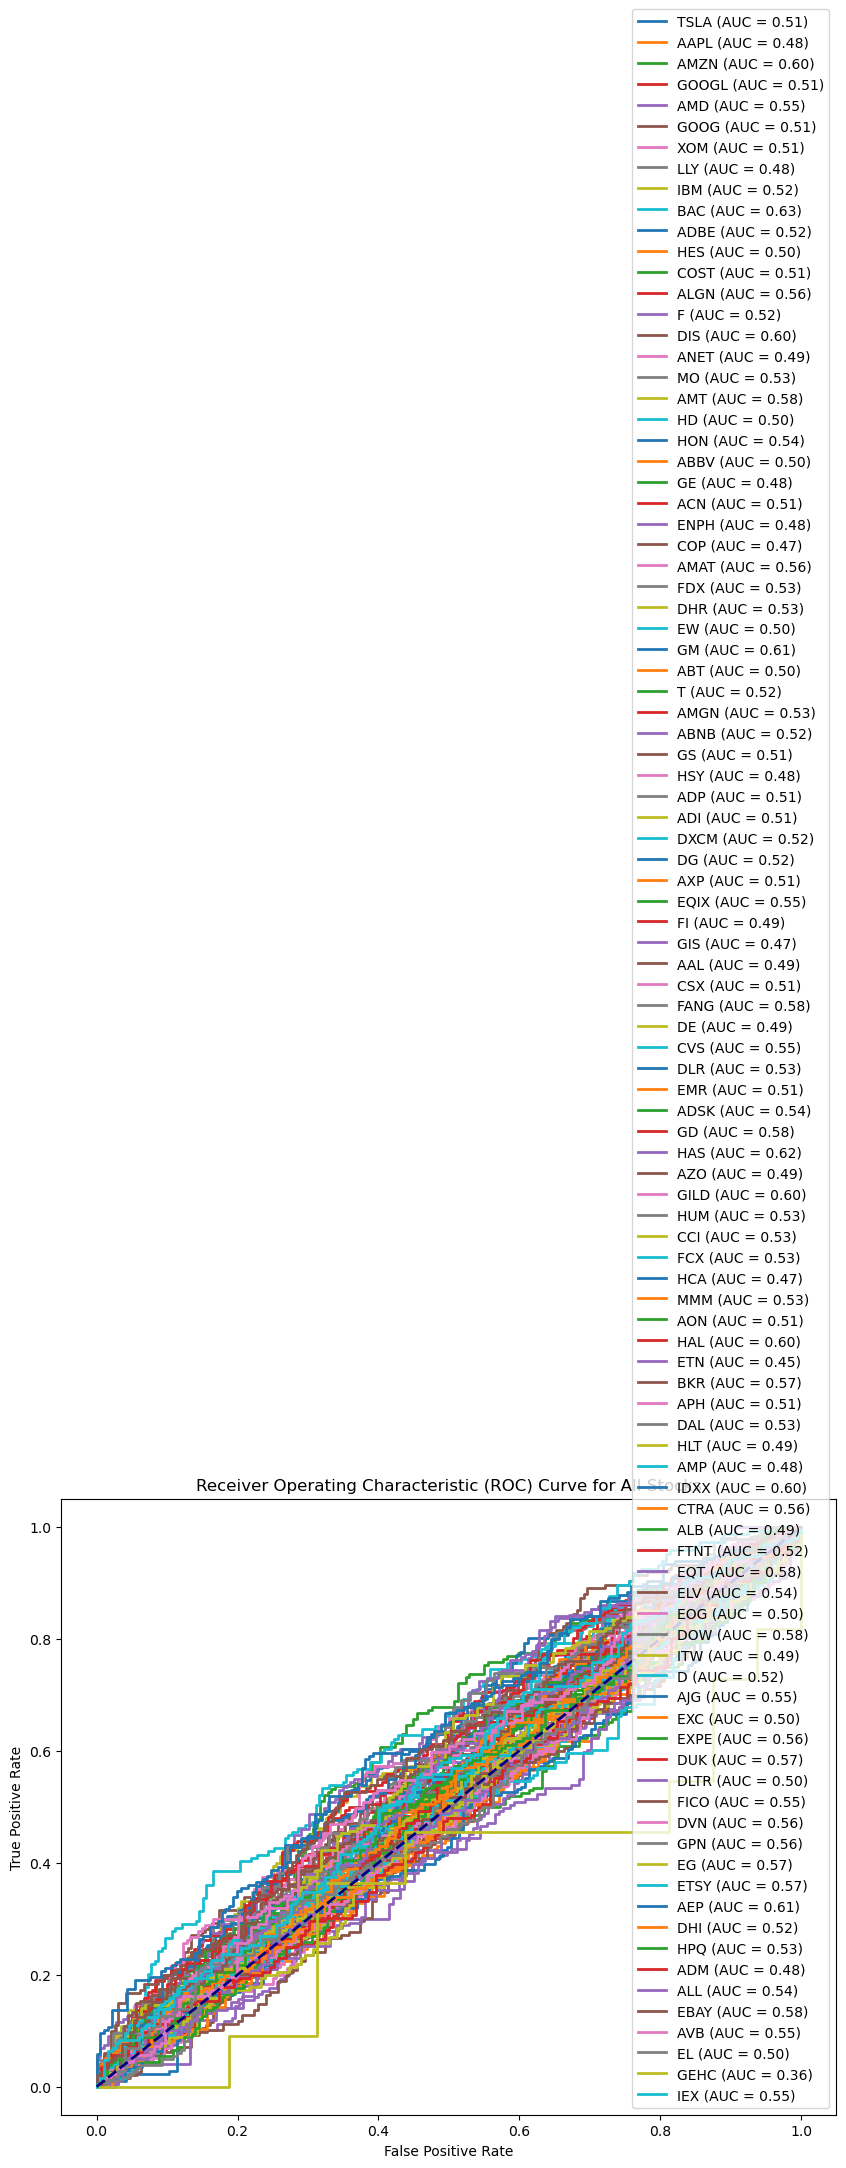

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# Loop through each ticker and its corresponding data in all_stock_data
for ticker, stock_data in all_stock_data.items():
    # Get the test data for the current stock
    X_test = stock_data['X_test']
    y_test = stock_data['y_test']
    
    # Predict probabilities using the neural network model
    y_prob = model.predict(X_test)
    
    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for the current model
    plt.plot(fpr, tpr, lw=2, label=f'{ticker} (AUC = {roc_auc:.2f})')

# Add the diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for All Stocks')
plt.legend(loc="lower right")

# Display the plot
plt.show()


Now we want to make a plot that ensembles all the roc plots

1141/1141 [==============================] - 2s 2ms/step


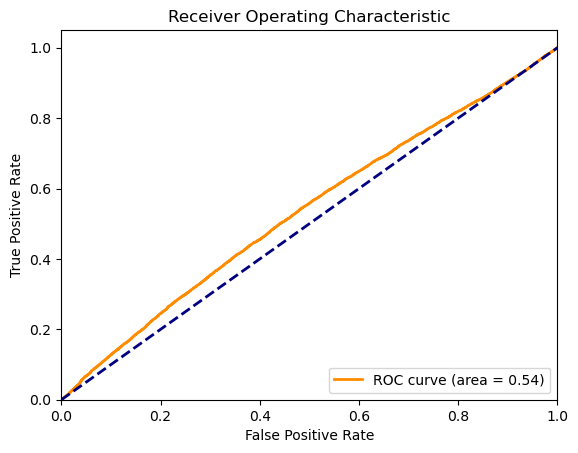

The AUC score is: 0.54


In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming model.predict(combined_X_val) returns the predicted probabilities
y_pred_probs = model.predict(combined_X_val).ravel()

# Compute ROC curve and ROC area for the actual validation data
fpr, tpr, thresholds = roc_curve(combined_y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
lw = 2  # line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"The AUC score is: {roc_auc:.2f}")


In [23]:
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

class AUCROC(Callback):
    def __init__(self, validation_data):
        self.X_val = validation_data[0]
        self.y_val = validation_data[1]
        self.auc_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_val = self.model.predict(self.X_val)
        auc_score = roc_auc_score(self.y_val, y_pred_val)
        self.auc_scores.append(auc_score)
        print(f'Epoch {epoch+1}: AUC = {auc_score:.4f}')

# We need to instantiate the callback with your validation data
auc_roc_callback = AUCROC(validation_data=(combined_X_val, combined_y_val))

# Then we pass this callback to the fit method
model.fit(combined_X_train, combined_y_train, epochs=150, batch_size=32, verbose=1,
          validation_data=(combined_X_val, combined_y_val), callbacks=[auc_roc_callback])


Epoch 1/150
1141/1141 [==============================] - 2s 2ms/step
Epoch 1: AUC = 0.5369
5326/5326 [==============================] - 16s 3ms/step - loss: 0.6639 - accuracy: 0.5846 - val_loss: 0.9092 - val_accuracy: 0.5267
Epoch 2/150
1141/1141 [==============================] - 2s 2ms/step
Epoch 2: AUC = 0.5369
5326/5326 [==============================] - 16s 3ms/step - loss: 0.6636 - accuracy: 0.5849 - val_loss: 1.0351 - val_accuracy: 0.5291
Epoch 3/150
1141/1141 [==============================] - 3s 3ms/step
Epoch 3: AUC = 0.5340
5326/5326 [==============================] - 20s 4ms/step - loss: 0.6637 - accuracy: 0.5850 - val_loss: 0.9369 - val_accuracy: 0.5304
Epoch 4/150
1141/1141 [==============================] - 2s 2ms/step
Epoch 4: AUC = 0.5385
5326/5326 [==============================] - 17s 3ms/step - loss: 0.6636 - accuracy: 0.5847 - val_loss: 0.9056 - val_accuracy: 0.5331
Epoch 5/150
1141/1141 [==============================] - 2s 2ms/step
Epoch 5: AUC = 0.5332
5326/5326

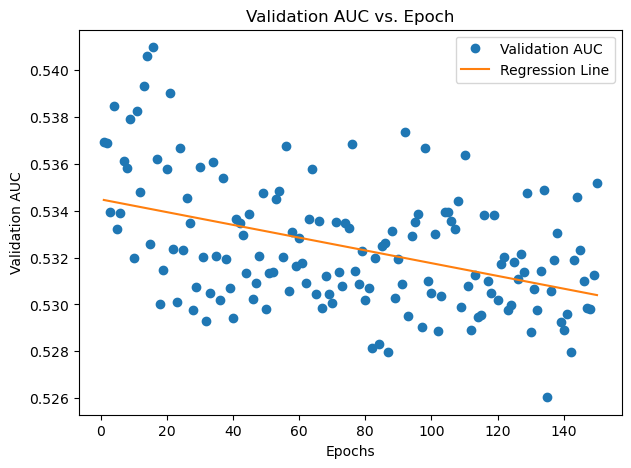

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_auc_vs_epochs(auc_roc_callback):
    epochs = range(1, len(auc_roc_callback.auc_scores) + 1)
    auc_scores = auc_roc_callback.auc_scores

    # Fitting a linear regression line
    m, b = np.polyfit(epochs, auc_scores, 1)
    regression_line = [m * x + b for x in epochs]

    # Plotting
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, auc_scores, 'o', label='Validation AUC')
    plt.plot(epochs, regression_line, '-', label='Regression Line')
    plt.title('Validation AUC vs. Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Validation AUC')
    plt.legend()
    plt.show()

# Example usage after the model has been trained:
plot_auc_vs_epochs(auc_roc_callback)


Epoch 1/50
44/44 [==============================] - 1s 10ms/step - loss: 14.4146 - accuracy: 0.5097 - val_loss: 7.2569 - val_accuracy: 0.4743
Epoch 2/50
44/44 [==============================] - 0s 3ms/step - loss: 4.2791 - accuracy: 0.5011 - val_loss: 5.0081 - val_accuracy: 0.5200
Epoch 3/50
44/44 [==============================] - 0s 3ms/step - loss: 2.6840 - accuracy: 0.5140 - val_loss: 6.0177 - val_accuracy: 0.5400
Epoch 4/50
44/44 [==============================] - 0s 3ms/step - loss: 2.3681 - accuracy: 0.5111 - val_loss: 3.8613 - val_accuracy: 0.5086
Epoch 5/50
44/44 [==============================] - 0s 4ms/step - loss: 2.1874 - accuracy: 0.5125 - val_loss: 3.8541 - val_accuracy: 0.4971
Epoch 6/50
44/44 [==============================] - 0s 3ms/step - loss: 1.8030 - accuracy: 0.5290 - val_loss: 5.4014 - val_accuracy: 0.4514
Epoch 7/50
44/44 [==============================] - 0s 3ms/step - loss: 1.6201 - accuracy: 0.5254 - val_loss: 4.0459 - val_accuracy: 0.4829
Epoch 8/50
44/44 [

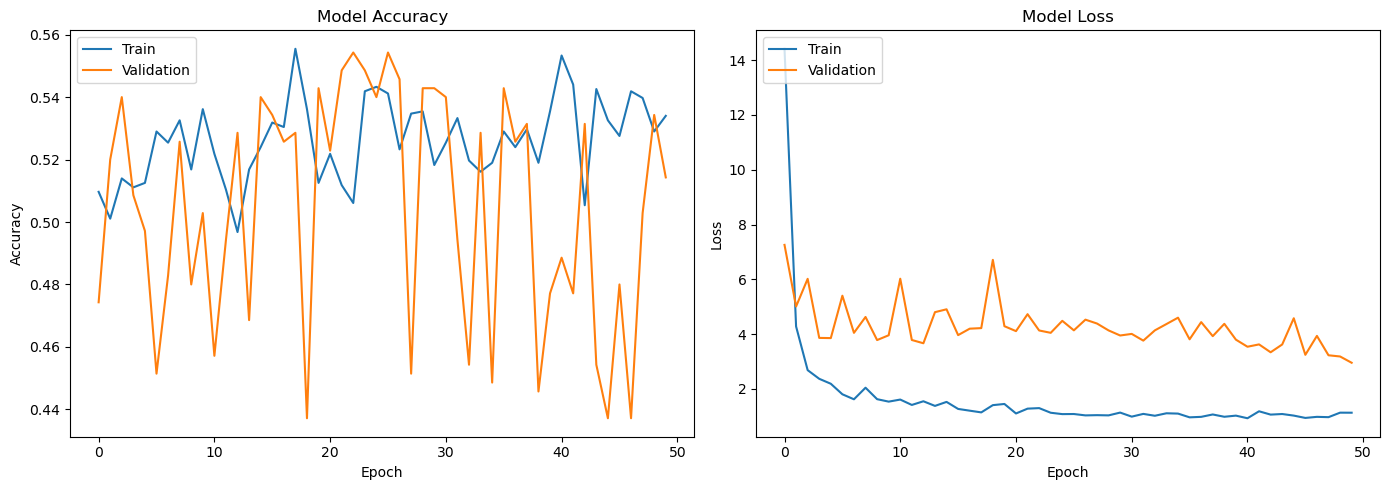

In [25]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training history of a Keras model.

    :param history: The history object returned by the fit method of a Keras model.
    """
    plt.figure(figsize=(14, 5))

    # Summarize history for accuracy, if it exists
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

    # Summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Example of using this function:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)
plot_training_history(history)


We look deeper into the training process of the model. Below we test if the model gets worse over time...

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

# Define the window size for the rolling evaluation
window_size = 25  

# Collect accuracies for all stocks
all_accuracies = []

# You'll need to replace 'model' with your actual trained model variable name
for ticker, data_splits in all_stock_data.items():
    X_test = data_splits['X_test']
    y_test = data_splits['y_test']
    X_test_index = X_test.index

    test_data_with_date = X_test.copy()
    test_data_with_date['label'] = y_test
    test_data_with_date['date'] = X_test_index

    accuracies = []

    for start in range(0, len(test_data_with_date) - window_size + 1):
        # Define the end of the window
        end = start + window_size

        # Slice the window of data
        window_data = test_data_with_date.iloc[start:end]
        X_window = window_data.drop(['date', 'label'], axis=1)
        y_window = window_data['label']

        # Make predictions for the current window
        y_pred_window = model.predict(X_window).round()  # Replace 'model' with your model variable

        # Calculate accuracy for the current window
        accuracy = accuracy_score(y_window, y_pred_window)
        accuracies.append(accuracy)

    all_accuracies.append(accuracies)

# Average the accuracies across all stocks for each time point
average_accuracies = np.mean(all_accuracies, axis=0)

# Prepare data for linear regression
dates = np.array(range(len(average_accuracies))).reshape(-1, 1)  # Simple integer index for dates
accuracies = np.array(average_accuracies).reshape(-1, 1)

# Linear regression
reg = LinearRegression().fit(dates, accuracies)
reg_line = reg.predict(dates)

# Plotting the average accuracy with a linear regression trend line
plt.figure(figsize=(14, 7))
plt.scatter(dates, accuracies, color='blue', label='Average Accuracy')
plt.plot(dates, reg_line, color='red', linewidth=2, label='Trend Line')
plt.xlabel('Time Point')
plt.ylabel('Average Accuracy')
plt.title('Average Model Accuracy Over Time with Linear Trend')
plt.legend()
plt.show()


1/1 [==============================] - 0s 43ms/step


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

We perform a statistical test on all the predictions and all the daily returns to see if there is a difference. We do it on all the stocks because we want as much data as possible.

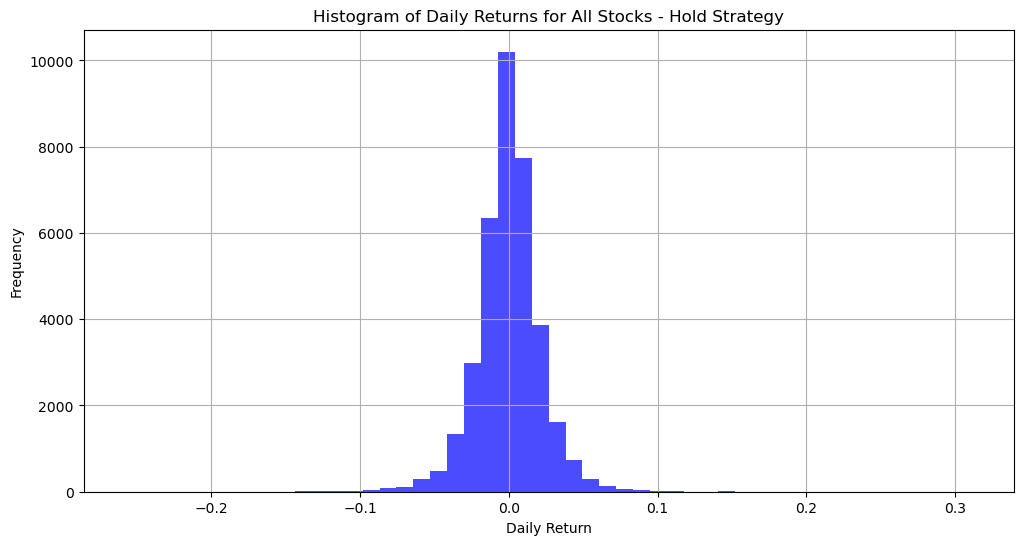

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming stock_results_HOLD is already defined and contains the results for each stock
# Initialize list to store daily returns for each stock
daily_returns_hold = []

for result in stock_results_HOLD:
    # Extract the actual daily returns
    actual_daily_returns = result['Actual Daily Returns']
    daily_returns_hold.append(actual_daily_returns)

# Flatten the list of daily returns to get a single array with all daily returns
all_daily_returns = np.concatenate(daily_returns_hold)

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.hist(all_daily_returns, bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Daily Returns for All Stocks - Hold Strategy")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


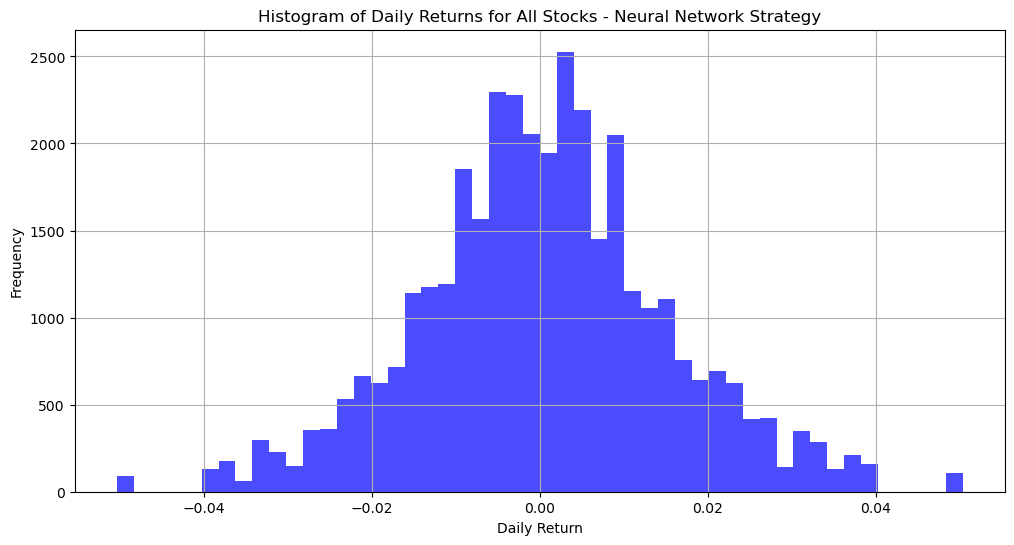

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten the DataFrame to get a single array with all daily returns for the strategy
all_strategy_daily_returns = df_strategy_daily_returns.values.flatten()

# Removing NaN values as they are not relevant for the histogram
all_strategy_daily_returns = all_strategy_daily_returns[~np.isnan(all_strategy_daily_returns)]

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.hist(all_strategy_daily_returns, bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Daily Returns for All Stocks - Neural Network Strategy")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


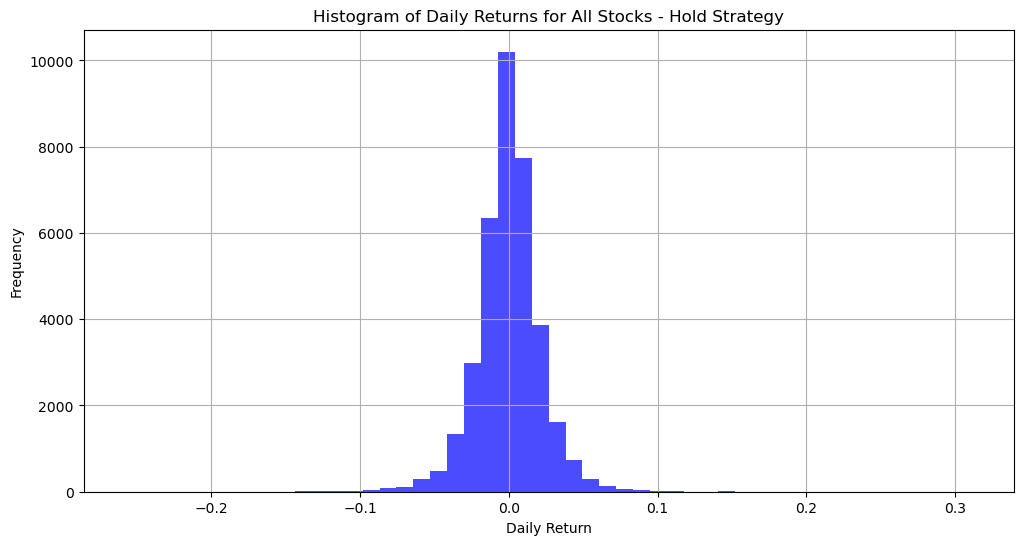

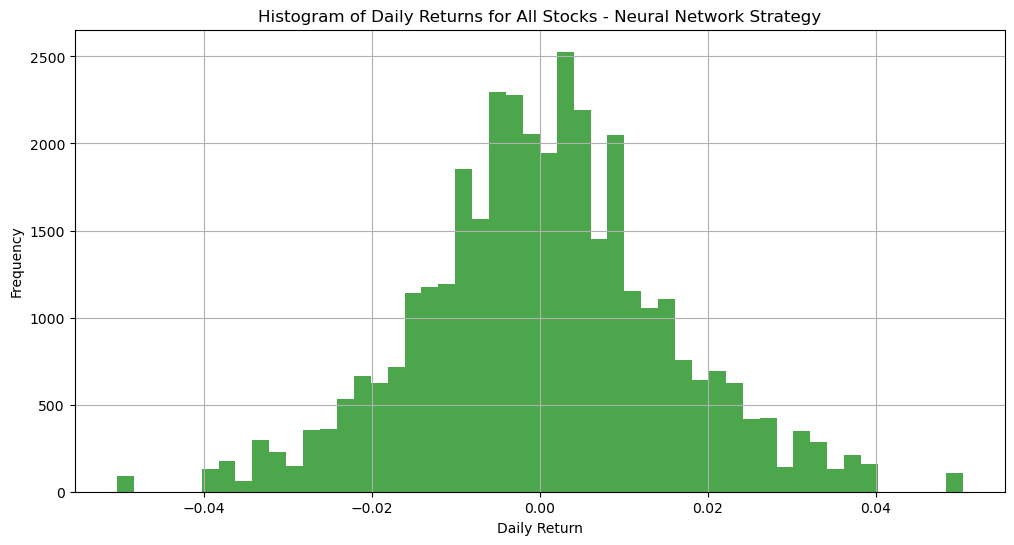

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming stock_results_HOLD and df_strategy_daily_returns are already defined and contain the necessary data
# For the hold strategy
daily_returns_hold = []
for result in stock_results_HOLD:
    actual_daily_returns = result['Actual Daily Returns']
    daily_returns_hold.append(actual_daily_returns)

# Flatten the list of daily returns for the hold strategy
all_daily_returns_hold = np.concatenate(daily_returns_hold)

# For the neural network strategy
all_strategy_daily_returns = df_strategy_daily_returns.values.flatten()
all_strategy_daily_returns = all_strategy_daily_returns[~np.isnan(all_strategy_daily_returns)]

# Plotting the histogram for the hold strategy
plt.figure(figsize=(12, 6))
plt.hist(all_daily_returns_hold, bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Daily Returns for All Stocks - Hold Strategy")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plotting the histogram for the neural network strategy
plt.figure(figsize=(12, 6))
plt.hist(all_strategy_daily_returns, bins=50, color='green', alpha=0.7)
plt.title("Histogram of Daily Returns for All Stocks - Neural Network Strategy")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [38]:
from scipy.stats import ttest_ind

# Assuming all_daily_returns_hold and all_strategy_daily_returns are already defined
# Remove NaN values from both arrays
all_daily_returns_hold_clean = all_daily_returns_hold[~np.isnan(all_daily_returns_hold)]
all_strategy_daily_returns_clean = all_strategy_daily_returns[~np.isnan(all_strategy_daily_returns)]

# Perform the t-test
t_stat, p_value = ttest_ind(all_daily_returns_hold_clean, all_strategy_daily_returns_clean, equal_var=False)

# Print the t-statistic and the p-value
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4g}")  # using 4 significant figures for the p-value

# Interpret the p-value
alpha = 0.05  # significance level
if p_value < alpha:
    print("We reject the null hypothesis (There is a significant difference between the strategies)")
else:
    print("We do not reject the null hypothesis (There is no significant difference between the strategies)")


T-statistic: -3.1013
P-value: 0.001928
We reject the null hypothesis (There is a significant difference between the strategies)
